In [30]:
## Long Short Term Memory (LSTM) Recurrent Neural Network (RNN)
## This video was guided by the following tutorial: https://www.youtube.com/watch?v=QIUxPv5PJOY

## This program considers the past 60 day stock price for predictions.

In [31]:
# !pip install --upgrade pandas-datareader
# !pip install yfinance

In [32]:
# Importing relevant libraries

import math
import pandas_datareader.data as web
import numpy as np
import pandas as pd
from sklearn.preprocessing import MinMaxScaler
from keras.models import Sequential
from keras.layers import Dense, LSTM
import matplotlib.pyplot as plt
plt.style.use('fivethirtyeight')

In [33]:
# Retrieve stock quotes

import yfinance as yf
yf.pdr_override()

df = web.get_data_yahoo('MSFT', start='2017-01-01', end='2023-09-10')

# Display data
df

[*********************100%%**********************]  1 of 1 completed


,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
2017-01-03,62.790001,62.840000,62.130001,62.580002,57.138729,20694100
2017-01-04,62.480000,62.750000,62.119999,62.299999,56.883068,21340000
2017-01-05,62.189999,62.660000,62.029999,62.299999,56.883068,24876000
2017-01-06,62.299999,63.150002,62.040001,62.840000,57.376133,19922900
2017-01-09,62.759998,63.080002,62.540001,62.639999,57.193512,20382700
...,...,...,...,...,...,...
2023-09-01,331.309998,331.989990,326.779999,328.660004,327.994293,14931200
2023-09-05,329.000000,334.850006,328.660004,333.549988,332.874359,18553900
2023-09-06,333.380005,334.459991,330.179993,332.880005,332.205750,17535800


In [34]:
# Retrieve matrix dimensions

df.shape

(1682, 6)

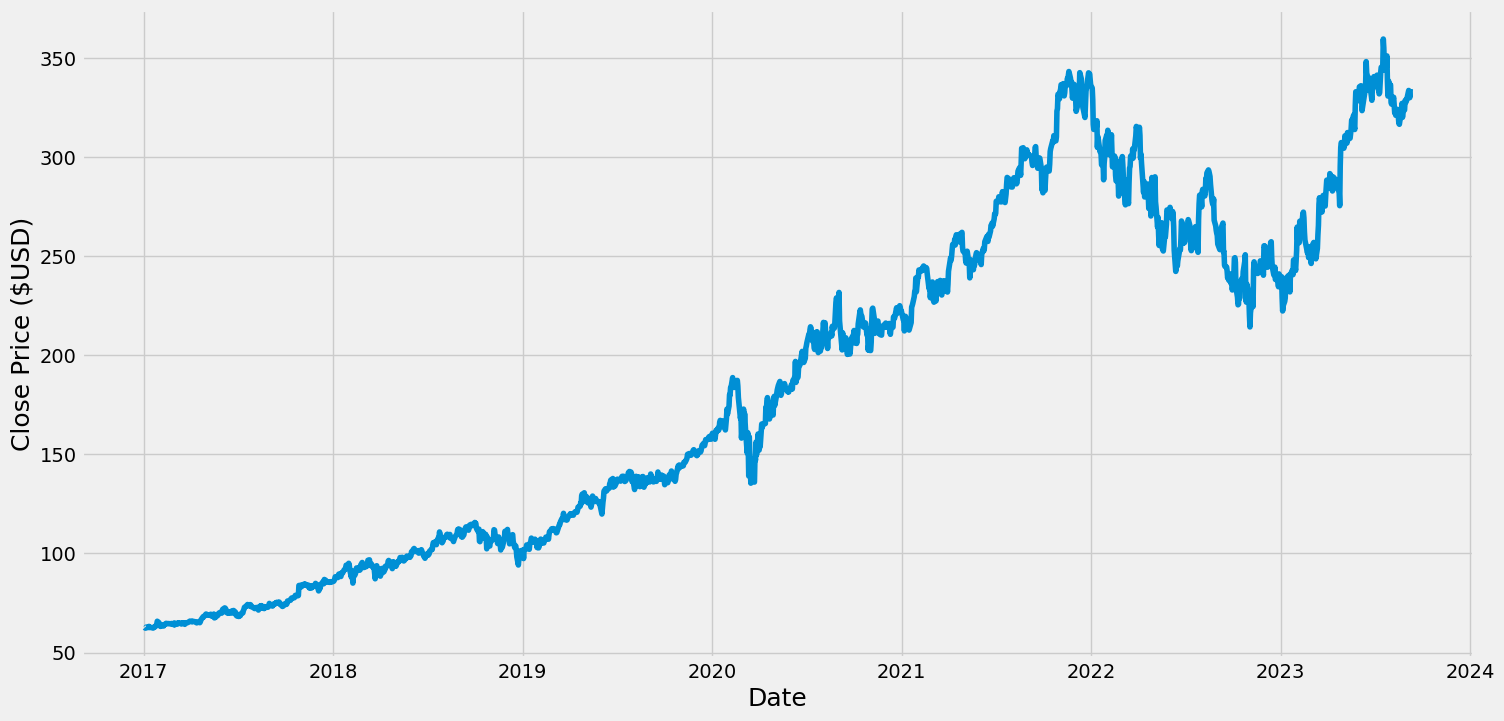

In [35]:
# Visualize the closing price

plt.figure(figsize=(16,8))
plt.title='Close Price History'
plt.plot(df['Close'])
plt.xlabel('Date', fontsize=18)
plt.ylabel('Close Price ($USD)', fontsize=18)

plt.show()

In [36]:
# Create a new dataframe with only closing prices

data = df.filter(['Close'])

# Convert dataframe to a numpy array
dataset = data.values

# Compute row count to train the model on => 80% of data for training
training_data_len = math.ceil(len(dataset) * 0.8)
print(training_data_len)

1346


In [37]:
# Scale the data for preprocessing

scaler = MinMaxScaler(feature_range=(0,1))
scaled_data = scaler.fit_transform(dataset)   # Computes min and max values for scaling, then transforms. Standardizes data from 0 to 1 inclusive

scaled_data

array([[0.00094217],
       [0.        ],
       [0.        ],
       ...,
       [0.91046137],
       [0.90046776],
       [0.91513846]])

In [39]:
# Create the training data set

# Create the scaled training data set
train_data = scaled_data[0:training_data_len, :]

# Split data into x_train and y_train data sets
x_train = []
y_train = []

for i in range(60, len(train_data)):
  x_train.append(train_data[i-60:i, 0])   # Positions 0 to 59
  y_train.append([train_data[i: i+9]])        # Position 60:69


IndexError: index 69 is out of bounds for axis 1 with size 1

In [ ]:
# Convert x_train and y_train to numpy arrays

x_train, y_train = np.array(x_train), np.array(y_train)

In [ ]:
# Reshape the x_train data set => Add third column

x_train = np.reshape(x_train, (x_train.shape[0], x_train.shape[1], 1))
x_train.shape

In [ ]:
# Build the LSTM Model

model = Sequential()
model.add(LSTM(64, return_sequences=True, input_shape=(x_train.shape[1], 1)))
model.add(LSTM(64, return_sequences=False)) 
model.add(Dense(32))

# model.add(Dense(1))
model.add(Dense(10))


In [ ]:
# Compile the model

# model.compile(optimizer='adam', loss='mean_squared_error')
model.compile(optimizer='adam', loss='mean_absolute_error')



In [ ]:
# Train the model

model.fit(x_train, y_train, batch_size=1, epochs=4)

In [ ]:
# Create the testing data set

# Array containing scaled values from index 1543 to 2003
test_data = scaled_data[training_data_len - 60: , :]

# Create the data sets x_test and y_test
x_test = []
y_test = dataset[training_data_len:, :]

for i in range(60, len(test_data)):
  x_test.append(test_data[i-60:i, 0])


In [ ]:
# Convert the data to a numpy array

x_test = np.array(x_test)


In [ ]:
# Reshape the data

x_test = np.reshape(x_test, (x_test.shape[0], x_test.shape[1], 1))  # Num of rows, num of columns, num of features (just the close price)


In [ ]:
# Retrieve model's predicted price values

predictions = model.predict(x_test)
predictions.shape

In [ ]:
predictions = scaler.inverse_transform(predictions)   # Unscale predictions to compare to original closing prices (y_test)

In [ ]:
# Evaluate root mean square error (RMSE) => Standard deviation of the residuals

rmse = np.sqrt( np.mean( predictions - y_test )**2 )
print(rmse)

In [ ]:
# Plot the data

train = data[:training_data_len].copy()
valid = data[training_data_len:].copy()

valid['Predictions'] = predictions[:,0]

# Visualize the data
plt.figure(figsize=(16,8))
plt.title='First Predicted Day'
plt.xlabel('Date', fontsize=18)
plt.ylabel('Close Price USD ($)', fontsize=18)
plt.plot(train['Close'][training_data_len-10:])
plt.plot(valid[['Close', 'Predictions']])

plt.legend(['Train', 'Val', 'Predictions'], loc='lower right')
plt.show()

In [ ]:
# Display valid and predicted prices
predictions

valid

In [ ]:
# Predict closing price for ^GSPC stock on december 18, 2019

#.Retrieve actual quote
apple_quote=web.get_data_yahoo('MSFT', start='2012-01-01', end='2023-09-05')

# Create a new dataframe
new_df = apple_quote.filter(['Close'])

# Retrieve only last 60 days of data and convert to array
last_sixty_days = new_df[-60:].values

# Scale the data to [0:1]
last_sixty_days_scaled = scaler.transform(last_sixty_days)

# Initialize list
new_x_test = []
new_x_test.append(last_sixty_days_scaled)

# Convert to numpy array
new_x_test = np.array(new_x_test)

# Reshape
new_x_test = np.reshape(new_x_test, (new_x_test.shape[0], new_x_test.shape[1], 1))
print(new_x_test)
# Calculate predictions
pred_price = model.predict(new_x_test)

# Rescale predictions
pred_price = scaler.inverse_transform(pred_price)


print(pred_price)

In [ ]:
# Evaluate efficacy of model

# Retrieve actual future quote data
actual_apple_quote=web.get_data_yahoo('MSFT', start='2023-09-05', end='2023-09-20')
print(actual_apple_quote['Close'])

In [ ]:
## Below code added as of 1/1/2023

In [ ]:
# Calculate confusion matrix from actual and predicted values

y_actual = y_test
y_hat = predictions

overshot = 0
undershot = 0


for i in range(0, len(y_actual)):
  if y_actual[i] > y_hat[i]:
    undershot+=1
  else:
    overshot+=1


print(np.average(y_actual-y_hat))
print(overshot, undershot)

